In [2]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
from pathlib import Path
import requests, json
from datetime import date, timedelta
%matplotlib inline

In [4]:
headers = {
'Accept': 'application/x-google-protobuf',
'Authorization': 'apikey vy2rFNXj4MRr2fuPWkB9etPZlz2yiD7NoWHl',
}

df_res = pd.DataFrame()
all_res = []

def get_carspaces(facility,date):

    url = f'https://api.transport.nsw.gov.au/v1/carpark/history?facility={facility}&eventdate={date}'

    response = requests.get(url, headers=headers, stream=True)
    
    json_string = json.loads(response.content)

    list_of_available = []
    list_timestamp = []
    df_car_spaces = pd.DataFrame()
    for x in range(len(json_string)):
        total = json_string[x]['occupancy']['total']
        timestamp = json_string[x]['MessageDate']
        spots = json_string[x]['spots']
        list_of_available.append( int(spots) - int(total))
        list_timestamp.append( timestamp)
    
    df_car_spaces['Timestamp'] = list_timestamp
    df_car_spaces['Available'] = list_of_available
    all_res.append(df_car_spaces)
    #df_car_spaces.to_csv(f'../Resources/car_spaces{date}.csv')

# Parse date range
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

# Set start and end datetimes of 1 month 
start_date = date(2022, 3, 11)
end_date = date(2022, 4, 18)
for single_date in daterange(start_date, end_date):
    #print(single_date.strftime("%Y-%m-%d"))
    # 14 - West Ryde Car Park
    get_carspaces(14,single_date)

df_res = pd.concat(all_res)
df_res.to_csv('../Resources/carspaces_data.csv')

In [5]:
csvpath = Path('../Resources/carspaces_data.csv')
df = pd.read_csv(csvpath, parse_dates=True, index_col='Timestamp')
df = df.drop(columns='Unnamed: 0')
df.head(5)

,Available
Timestamp,
2022-03-11 00:00:46,148
2022-03-11 00:10:47,148
2022-03-11 00:20:49,148
2022-03-11 00:30:51,148
2022-03-11 00:40:52,148


<AxesSubplot:xlabel='Timestamp'>

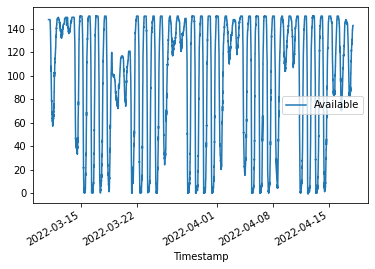

In [6]:

df.plot()

In [7]:
df['Return'] = df.Available.pct_change() * 100 
df = df.resample('5min').mean()
df = df.dropna()
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
df.head()

,Available,Return
Timestamp,,
2022-03-11 00:10:00,148.0,0.0
2022-03-11 00:20:00,148.0,0.0
2022-03-11 00:30:00,148.0,0.0
2022-03-11 00:40:00,148.0,0.0
2022-03-11 00:50:00,148.0,0.0


<AxesSubplot:xlabel='Timestamp'>

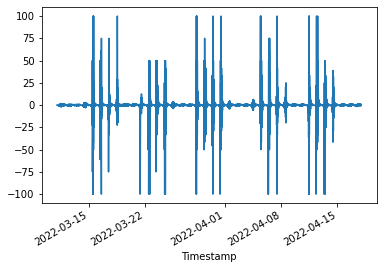

In [8]:
df.Return.plot()

In [9]:
# Create the GARCH model
from arch import arch_model
model = arch_model(df.Return, mean="Zero", vol="GARCH", p=2, q=2)
results = model.fit(disp="off")
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -11269.2
Distribution:                  Normal   AIC:                           22548.4
Method:            Maximum Likelihood   BIC:                           22582.9
                                        No. Observations:                 7370
Date:                Tue, Apr 19 2022   Df Residuals:                     7370
Time:                        11:36:01   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0107  3.387e-03      3.157  1.596e-03 [4.052e-03,1.733e-02]
alpha[1]       0.2639  2.765e-02      9.543  1.385e-21     [  0.210,  0.318]
alpha[2]       0.0822      0.107      0.765      0.444     [ -0.128,  0.293]
beta[1]        0.6539      0.334      1.959  5.006e-02  [-1.698e-04,  1.308]
beta[2]    3.1601e-07      0.230  1.377e-06      1.000     [ -0.450,  0.450]
============================================================================

Covariance estimator: robust
"""

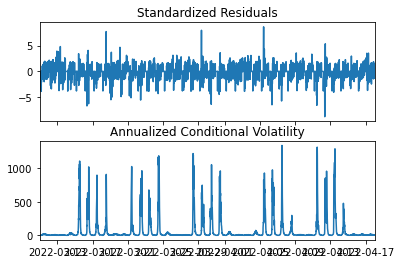

In [11]:
# Plot the model estimate of the annualized volatility
fig = results.plot(annualize='D')

In [15]:
# Find the last day of the dataset
last_day = df.index.max().strftime('%Y-%m-%d-%T')
last_day

'2022-04-17-23:50:00'

In [16]:
# Create a 5 day forecast of EUR to CAD exchange rate volatility
forecast_horizon = 15
# Take the last day of the data we used above. 
# If forecast horizon is 3, then the resulting 'h.1', 'h.2', and 'h.3' 
# are the forecasts for the following 3 days.
forecasts = results.forecast(start=df.index.max(), horizon=forecast_horizon)

# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 365 )
intermediate.head()

/home/hkolli/miniconda3/envs/algotrading/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,h.11,h.12,h.13,h.14,h.15
Timestamp,,,,,,,,,,,,,,,
2022-04-17 23:50:00,7.761022,7.69327,7.948218,8.169962,8.387871,8.600098,8.807225,9.009591,9.20751,9.401263,9.591104,9.777259,9.959935,10.139321,10.315587
